# First Scikit learn models on sampled data in DashDB


In [81]:
!pip install -U scikit-learn
print sklearn.__version__
!pip install xgboost


    100% |████████████████████████████████| 1.2MB 989kB/s 
  Running setup.py install for xgboost ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import sklearn
import xgboost

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score,roc_curve, auc



import ibmdbpy
from ibmdbpy import IdaDataBase,IdaDataFrame

/gpfs/fs01/user/s16e-7918d85e6de098-7a7840b6cba3/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Get data from DashDB

In [3]:
credentials_1 = {
  'host':'awh-yp-small03.services.dal.bluemix.net',
  'port':'50000',
  'user':'dash110459',
  'password':"""cc7fcfe60374""",
  'database':'BLUDB'
}

idadb = IdaDataBase(dsn="DASHDB;Database=BLUDB;Hostname=" + credentials_1["host"] + ";Port=50000;PROTOCOL=TCPIP;UID=" + credentials_1["user"] + ";PWD=" + credentials_1["password"])
data_train = IdaDataFrame(idadb, 'DATA_TRAIN')
data_train = data_train.as_dataframe()
data_train.head()

Exception AttributeError: "Cursor instance has no attribute 'closed'" in <bound method Cursor.__del__ of <pypyodbc.Cursor instance at 0x7f5d1e0c1a70>> ignored


,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,v11,v12,v13,v14,v15,target
0,-0.581274,0.299583,0.672571,0.879624,1.417787,12273.412584,11.577250,1,0,1,0,2,4,1,3,0
1,0.102360,0.942390,1.358432,1.289167,3.519207,12273.412584,8.978558,1,1,1,2,1,1,2,6,1
2,-0.131057,0.796321,1.218057,1.704464,0.582041,12273.412584,10.950337,1,1,1,2,0,3,3,0,1
3,-1.664699,0.972988,2.604471,1.165724,4.582620,12273.412584,12.149130,1,1,1,1,0,2,3,0,0
4,1.018567,0.796813,1.549261,5.730283,0.854525,12273.412584,8.379034,1,1,0,0,0,3,0,9,1


Transform the categorical features in dummies and create train/test data.

In [4]:
cat_columns = data_train.select_dtypes(['integer']).columns
cat_columns=cat_columns.drop('target')

data_train[cat_columns] = data_train[cat_columns].apply(lambda x: x.astype('category'))
#data_train.dtypes

data_train = pd.get_dummies(data_train)

X_train, X_test, y_train, y_test = train_test_split(data_train.drop('target',axis=1), data_train.target, test_size=0.5)

# KNN

In [77]:
#scaler = StandardScaler().fit(X_train)
#X_train_transformed = scaler.transform(X_train)
#X_test_transformed = scaler.transform(X_test)

parameters = {'weights':['uniform', 'distance'], 'n_neighbors':[8, 12],'p':[1,2]}
#parameters = {'n_neighbors':[8, 12]}

knn = KNeighborsClassifier(n_jobs=10)
grid = GridSearchCV(knn, parameters, cv=10, scoring='roc_auc')             
#grid.fit(X_train_transformed, y_train)
grid.fit(X_train, y_train)
print (grid.best_estimator_)

#y_pred_knn=grid.predict_proba(X_test_transformed)[:,1]
y_pred_knn=grid.predict_proba(X_test)[:,1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
print('AUC KNN=',auc(fpr_knn, tpr_knn))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=9, n_neighbors=12, p=1,
           weights='distance')
('AUC KNN=', 0.96606935548423456)


# Random Forest

In [13]:
parameters = {'n_estimators':[100,250,500]}

rf = RandomForestClassifier(n_jobs=10)
grid = GridSearchCV(rf, parameters, cv=10, scoring='roc_auc')             
grid.fit(X_train, y_train)
print (grid.best_estimator_)

y_pred_rf=grid.predict_proba(X_test)[:,1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print('AUC RF=',auc(fpr_rf, tpr_rf))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=10, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
('AUC RF=', 0.98634499345189552)


# Gradient Boosting

('AUC XGB=', 0.98766002383414542)


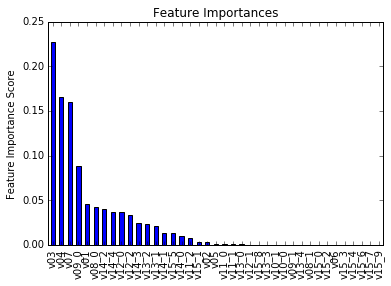

In [10]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb=xgb.predict_proba(X_test)[:,1]

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
print('AUC XGB=',auc(fpr_xgb, tpr_xgb))

feat_imp = pd.Series(xgb.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')


In [16]:
parameters = {'n_estimators':[100,250,500]}

xgb = xgboost.XGBClassifier(nthread=10)
#xgb = xgboost.XGBClassifier(learning_rate=0.005, max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,warm_start=True)

grid = GridSearchCV(xgb, parameters, cv=10, scoring='roc_auc')             
grid.fit(X_train, y_train)
print (grid.best_estimator_)

y_pred_xgb=grid.predict_proba(X_test)[:,1]

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_rf)
print('AUC XGB=',auc(fpr_xgb, tpr_xgb))


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=10,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
('AUC XGB=', 0.98634499345189552)


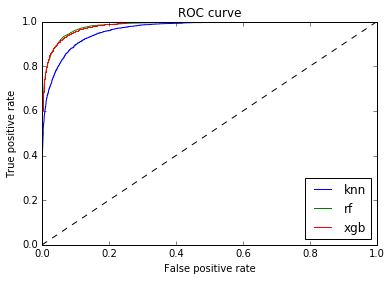

In [84]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label='knn')
plt.plot(fpr_rf, tpr_rf, label='rf')
plt.plot(fpr_xgb, tpr_xgb, label='xgb')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

